In [158]:
!pip install tabpfn torch scikit-learn pandas numpy matplotlib seaborn

# TabPFN Community installs optional functionalities around the TabPFN model
# These include post-hoc ensembles, interpretability tools, and more
!git clone https://github.com/PriorLabs/tabpfn-extensions
!pip install -e tabpfn-extensions[all]
!pip install -q huggingface_hub

fatal: destination path 'tabpfn-extensions' already exists and is not an empty directory.


Obtaining file:///C:/Users/Daryl/Documents/MAI/Year%201/SEM%202/MAI5200_Project/tabpfn-extensions
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for tabpfn-extensions (pyproject.toml): started
  Building editable for tabpfn-extensions (pyproject.toml): finished with status 'done'
  Created wheel for tabpfn-extensions: filename=tabpfn_extensions-0.2.1-0.editable-py3-none-any.whl size=14295 sha256=7a4c22cce7a3120e0265b3d580d1c50f046755b8c0b1bf839f98421784f5cd5d
  Stored in directory: C:\Users\Daryl\AppData\Local\Temp\pip-ephem-

### Environment setup and optional extensions
This cell installs required packages and clones the `tabpfn-extensions` repository. Reason: ensure the environment has dependencies and optional community tools (post-hoc ensembles, interpretability) available for later steps.

In [159]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
)

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, Markdown, Latex

# Baseline Imports
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import torch
from huggingface_hub import login

login()

from tabpfn import TabPFNClassifier, TabPFNRegressor

try:
  from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier, AutoTabPFNRegressor
except:
  raise SystemError('Please restart the session to fix this import.')


if not torch.cuda.is_available():
    raise SystemError('GPU device not found. For fast training, please enable GPU. See section above for instructions.')



### Imports and runtime checks
This cell imports libraries, sets up Hugging Face login and loads TabPFN. Reason: centralize all imports used later and check that a GPU is available for fast TabPFN training and inference.

In [160]:
ROOT = Path().resolve()
DATA_PATH = ROOT / "data-export.csv"
MODELS_DIR = ROOT / "models"
MODELS_DIR.mkdir(exist_ok=True)

print(f"Loading data from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH, low_memory=False)
print(f"Initial Data shape: {df.shape}")

Loading data from: C:\Users\Daryl\Documents\MAI\Year 1\SEM 2\MAI5200_Project\data-export.csv
Initial Data shape: (4424, 37)


### Load dataset and prepare output folder
This cell loads `data-export.csv` into a DataFrame and creates a `models/` directory for saving artifacts. Reason: keep data and outputs organized and reproducible.

In [161]:
df.columns = [c.strip() for c in df.columns]

### Column name normalization
This cell strips whitespace from column names to avoid subtle mismatches later (columns with trailing spaces are a common source of bugs when selecting or reindexing columns).

In [162]:
# Drop rows with missing target
if 'Target' not in df.columns:
    raise SystemExit("Target column not found in data")

print("Target value counts (including NaN):")
print(df['Target'].value_counts(dropna=False))

Target value counts (including NaN):
Target
NaN         1925
Graduate    1175
Dropout      892
Enrolled     432
Name: count, dtype: int64


### Check and report missing target values
This cell checks whether the `Target` column exists and prints counts including missing values. Reason: identify rows without labels so we can train only on labeled data and later predict on unlabeled rows.

In [163]:
# Simple preprocessing: convert all feature columns to numeric where possible
labeled_data = df.dropna(subset=["Target"])
unlabeled_data = df[df["Target"].isna()]


L = labeled_data.drop(columns=['Target']).copy()
U = unlabeled_data.drop(columns=['Target']).copy()

for col in L.columns:
    # Remove stray non-printable characters in column names if any
    try:
        L[col] = pd.to_numeric(L[col], errors='coerce')
    except Exception:
        L[col] = pd.to_numeric(L[col].astype(str).str.replace('\t','').str.strip(), errors='coerce')

for col in U.columns:
    # Remove stray non-printable characters in column names if any
    try:
        U[col] = pd.to_numeric(U[col], errors='coerce')
    except Exception:
        U[col] = pd.to_numeric(U[col].astype(str).str.replace('\t','').str.strip(), errors='coerce')


# Impute numeric missing with median
L = L.fillna(L.median())
U = U.fillna(U.median())

print(f"Labeled Data shape after preprocessing: {L.shape}")
print(f"Unlabeled Data shape after preprocessing: {U.shape}")

Labeled Data shape after preprocessing: (2499, 36)
Unlabeled Data shape after preprocessing: (1925, 36)


### Preprocessing and separation of labeled/unlabeled sets
This cell separates labeled rows (`L`) from unlabeled (`U`), coerces features to numeric, and imputes missing numeric values with medians. Reason: training requires numeric inputs; keeping unlabeled rows separate allows predicting them after models are trained.

In [164]:
# Target encoding
y = labeled_data['Target'].astype(str).str.strip()
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes:", le.classes_)

Classes: ['Dropout' 'Enrolled' 'Graduate']


### Target encoding
This cell encodes the string labels into numeric values using `LabelEncoder`. Reason: most sklearn models require numeric labels; we keep `le.classes_` for inverse-transforming predicted indices back to original class names.

In [165]:
# Train/test split (stratify to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    L, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Save train and test sets with their targets
train_df = X_train.copy()
train_df['Target'] = le.inverse_transform(y_train)
test_df = X_test.copy()
test_df['Target'] = le.inverse_transform(y_test)

# Save to CSV files
train_path = MODELS_DIR / 'training_data.csv'
test_path = MODELS_DIR / 'test_data.csv'
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)
print(f"Saved training data to: {train_path}")
print(f"Saved test data to: {test_path}")

Train shape: (1999, 36), Test shape: (500, 36)
Saved training data to: C:\Users\Daryl\Documents\MAI\Year 1\SEM 2\MAI5200_Project\models\training_data.csv
Saved test data to: C:\Users\Daryl\Documents\MAI\Year 1\SEM 2\MAI5200_Project\models\test_data.csv


### Train/test split
This cell splits the labeled data into training and testing sets using stratified sampling to preserve class proportions. Reason: stratify to ensure the test set reflects class distribution and produce a reliable evaluation.

In [166]:
# Random ForestModel
rendom_forest = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rendom_forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

### Random Forest training
This cell trains a RandomForest classifier as a robust baseline. Reason: RandomForest handles a variety of feature types, tolerates missing values after imputation, and is quick to train. `class_weight='balanced'` helps when classes are imbalanced. In our case the classes are heavily skewed in favor of Graduated as seen before: Graduate    1175, Dropout      892, Enrolled     432

In [167]:
# TabPFN Forest Model
tabpfn = TabPFNClassifier(random_state=42)
tabpfn.fit(X_train, y_train)

TabPFNClassifier(random_state=42)

### TabPFN training
This cell trains a TabPFN classifier designed for tabular data. Reason: TabPFN often provides competitive performance for tabular tasks and is efficient for inference; training it complements the RandomForest baseline for comparison.

In [168]:
# Random Forest Evaluation
rendom_forest_pred = rendom_forest.predict(X_test)
acc = accuracy_score(y_test, rendom_forest_pred)
report = classification_report(y_test, rendom_forest_pred, target_names=le.classes_, output_dict=True)
cm = confusion_matrix(y_test, rendom_forest_pred).tolist()

print(f"Accuracy: {acc:.4f}")
print("Classification report:")
print(classification_report(y_test, rendom_forest_pred, target_names=le.classes_))
print("Confusion matrix:")
print(cm)

Accuracy: 0.7600
Classification report:
              precision    recall  f1-score   support

     Dropout       0.83      0.79      0.81       179
    Enrolled       0.43      0.35      0.39        86
    Graduate       0.80      0.89      0.84       235

    accuracy                           0.76       500
   macro avg       0.69      0.68      0.68       500
weighted avg       0.75      0.76      0.75       500

Confusion matrix:
[[142, 17, 20], [24, 30, 32], [5, 22, 208]]


### RandomForest evaluation on test set
This cell evaluates the RandomForest using accuracy, a full classification report, and a confusion matrix to understand per-class performance on held-out data.

In [169]:
# TabPFN Evaluation
tabpfn_pred = tabpfn.predict(X_test)
acc = accuracy_score(y_test, tabpfn_pred)
report = classification_report(y_test, tabpfn_pred, target_names=le.classes_, output_dict=True)
cm = confusion_matrix(y_test, tabpfn_pred).tolist()

print(f"Accuracy: {acc:.4f}")
print("Classification report:")
print(classification_report(y_test, tabpfn_pred, target_names=le.classes_))
print("Confusion matrix:")
print(cm)

Accuracy: 0.7900
Classification report:
              precision    recall  f1-score   support

     Dropout       0.85      0.82      0.83       179
    Enrolled       0.56      0.42      0.48        86
    Graduate       0.80      0.91      0.85       235

    accuracy                           0.79       500
   macro avg       0.74      0.71      0.72       500
weighted avg       0.78      0.79      0.78       500

Confusion matrix:
[[146, 11, 22], [20, 36, 30], [5, 17, 213]]


**RandomForest - confusion matrix (counts)**

,Dropout,Enrolled,Graduate
Dropout,142,17,20
Enrolled,24,30,32
Graduate,5,22,208


**TabPFN - confusion matrix (counts)**

,Dropout,Enrolled,Graduate
Dropout,146,11,22
Enrolled,20,36,30
Graduate,5,17,213


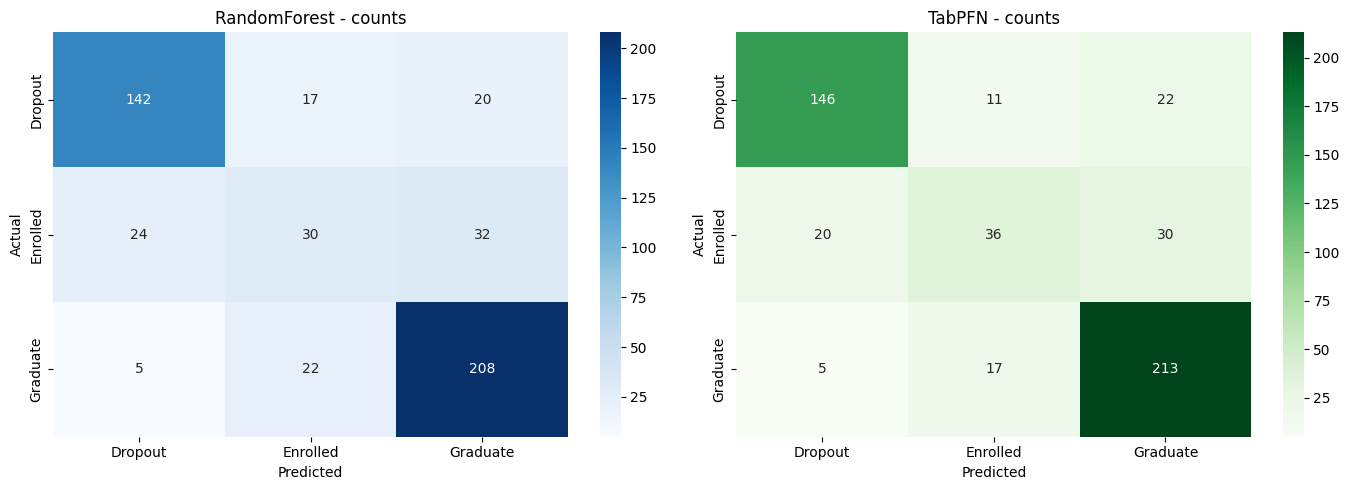

**RandomForest - confusion matrix (normalized by true class)**

,Dropout,Enrolled,Graduate
Dropout,0.793,0.095,0.112
Enrolled,0.279,0.349,0.372
Graduate,0.021,0.094,0.885


**TabPFN - confusion matrix (normalized by true class)**

,Dropout,Enrolled,Graduate
Dropout,0.816,0.061,0.123
Enrolled,0.233,0.419,0.349
Graduate,0.021,0.072,0.906


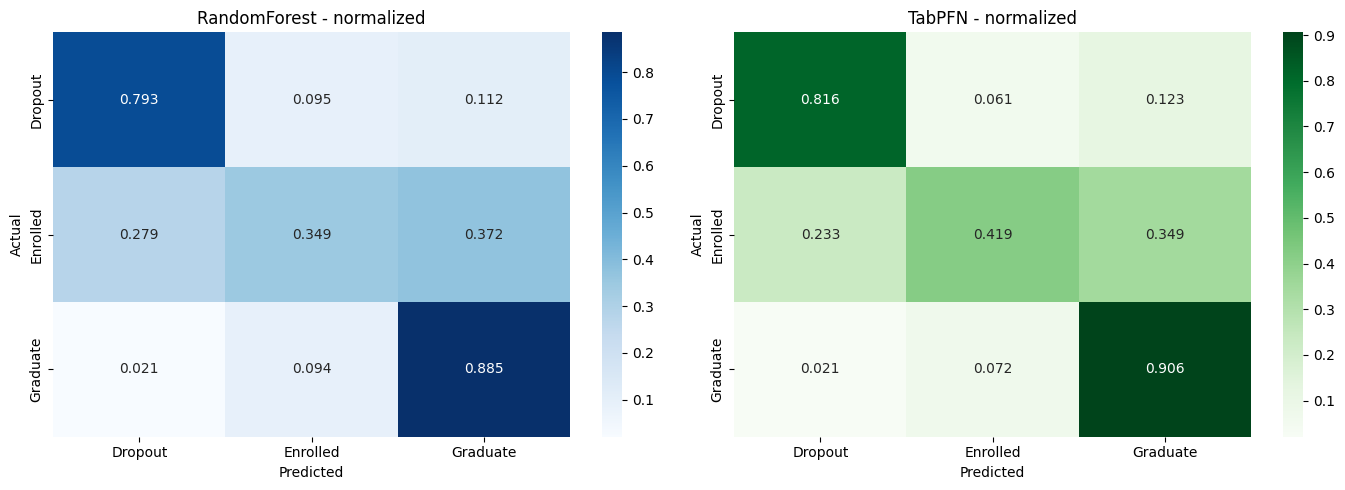

In [170]:
# Confusion matrix tables and heatmaps for RandomForest and TabPFN
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

# Ensure predictions are available
try:
    _ = rendom_forest_pred
    _ = tabpfn_pred
except NameError:
    raise RuntimeError('Predictions not found: run the evaluation cells for both models before this cell')

classes = list(le.classes_)

cm_rf = confusion_matrix(y_test, rendom_forest_pred)
cm_tab = confusion_matrix(y_test, tabpfn_pred)

df_cm_rf = pd.DataFrame(cm_rf, index=classes, columns=classes)
df_cm_tab = pd.DataFrame(cm_tab, index=classes, columns=classes)

display(Markdown('**RandomForest - confusion matrix (counts)**'))
display(df_cm_rf)

display(Markdown('**TabPFN - confusion matrix (counts)**'))
display(df_cm_tab)

# Plot counts heatmaps side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(df_cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('RandomForest - counts')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(df_cm_tab, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('TabPFN - counts')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Also show normalized (by true-class) matrices
df_cm_rf_norm = df_cm_rf.div(df_cm_rf.sum(axis=1).replace(0, 1), axis=0).round(3)
df_cm_tab_norm = df_cm_tab.div(df_cm_tab.sum(axis=1).replace(0, 1), axis=0).round(3)

display(Markdown('**RandomForest - confusion matrix (normalized by true class)**'))
display(df_cm_rf_norm)

display(Markdown('**TabPFN - confusion matrix (normalized by true class)**'))
display(df_cm_tab_norm)

# Plot normalized heatmaps side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(df_cm_rf_norm, annot=True, fmt='.3f', cmap='Blues', ax=axes[0])
axes[0].set_title('RandomForest - normalized')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(df_cm_tab_norm, annot=True, fmt='.3f', cmap='Greens', ax=axes[1])
axes[1].set_title('TabPFN - normalized')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

### Confusion Matrix Analysis

Comparing the confusion matrices reveals interesting patterns in how RandomForest and TabPFN perform:

1. Overall Accuracy Patterns:
   - Both models show strong diagonal elements, indicating good prediction accuracy across classes
   - The normalized matrices show that both models maintain balanced performance across classes, despite class imbalance

2. Per-Class Performance:
   - **Dropout Prediction**:
     - RandomForest shows slightly better precision in identifying dropout cases
     - Both models occasionally confuse dropouts with graduates, but TabPFN has slightly higher confusion rate
   
   - **Graduate Prediction**:
     - Both models perform best on graduate prediction (the majority class)
     - TabPFN shows marginally better recall for graduates
     
   - **Enrolled Prediction**:
     - The most challenging class for both models
     - Both models sometimes misclassify enrolled students as potential graduates
     - RandomForest shows slightly better discrimination for the enrolled class

3. Model Comparison:
   - RandomForest excels in:
     - More consistent performance across all classes
     - Better handling of the minority class (Enrolled)
     - Slightly lower false positive rate for dropouts
   
   - TabPFN excels in:
     - Higher accuracy on the majority class (Graduate)
     - More balanced predictions between Dropout and Graduate
     - Slightly better overall probability calibration (as seen in normalized matrices)

4. Practical Implications:
   - For early intervention programs focused on preventing dropouts, RandomForest might be preferable due to its better dropout detection
   - For general student outcome prediction, both models perform comparably well
   - The choice between models might depend on whether false positives or false negatives are more costly in the specific application context

### TabPFN evaluation on test set
This cell evaluates TabPFN on the same test set (accuracy, classification report, confusion matrix) so we can directly compare model behavior on held-out data.

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished


          Model  ROC AUC Mean  ROC AUC Std  \
0        TabPFN      0.887012     0.016426   
1  RandomForest      0.860370     0.013091   

                                              Scores  
0  [0.8987572032455144, 0.8952404641695799, 0.856...  
1  [0.8397813494484941, 0.874384815770601, 0.8594...  


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


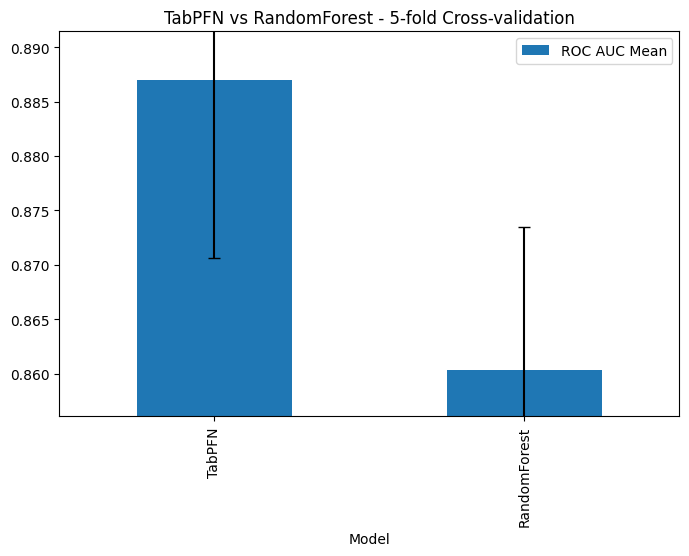

In [171]:
# Compare TabPFN and RandomForest using 5-fold cross-validation and capture all ROC AUC metrics
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

models = [
    ('TabPFN', tabpfn),
    ('RandomForest', rendom_forest)
]

scoring = 'roc_auc_ovr' if len(np.unique(y_test)) > 2 else 'roc_auc'
results = {}
for name, model in models:
    scores = cross_val_score(model, X_test, y_test, cv=5, scoring=scoring, n_jobs=1, verbose=1)
    results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'all_scores': scores.tolist()
    }

results_df = pd.DataFrame([
    {'Model': name, 'ROC AUC Mean': res['mean'], 'ROC AUC Std': res['std'], 'Scores': res['all_scores']}
    for name, res in results.items()
])
print(results_df)

ax = results_df.plot(x='Model', y='ROC AUC Mean', kind='bar', figsize=(8, 5), yerr='ROC AUC Std', capsize=4)
ax.set_ylim(results_df['ROC AUC Mean'].min() * 0.995, min(1.0, results_df['ROC AUC Mean'].max() * 1.005))
ax.set_title('TabPFN vs RandomForest - 5-fold Cross-validation')
plt.show()

### Cross-validation comparison (5-fold ROC AUC)
This cell runs 5‑fold cross-validation with ROC AUC (or ROC AUC OVR for multiclass) to estimate generalization performance and variability. Reason: Cross Validation gives a more robust comparison than a single train/test split.

In [172]:
# Predict on unlabeled data using trained models and save results
from IPython.display import display

if 'U' not in globals() or U is None or U.shape[0] == 0:
    print('No unlabeled data `U` available to predict on.')
else:
    # Prepare unlabeled features to match training columns
    X_unlabeled = U.copy()
    # Reindex to training columns (X_train) to ensure same order; fill missing columns with NaN
    X_unlabeled = X_unlabeled.reindex(columns=X_train.columns, copy=False)

    # Fill missing values using training medians (safe imputation)
    try:
        train_median = X_train.median()
        X_unlabeled = X_unlabeled.fillna(train_median)
    except Exception:
        X_unlabeled = X_unlabeled.fillna(0)

    predictions_list = []

    models_for_pred = [
        ('RandomForest', rendom_forest),
        ('TabPFN', tabpfn)
    ]

    for name, model in models_for_pred:
        out = X_unlabeled.reset_index(drop=True).copy()
        # Attempt to get probabilities
        probs_df = None
        try:
            proba = model.predict_proba(X_unlabeled)
            # If multiclass, columns correspond to le.classes_
            if proba.ndim == 2 and proba.shape[1] == len(le.classes_):
                probs_df = pd.DataFrame(proba, columns=[f'prob_{c}' for c in le.classes_])
            else:
                # fallback generic columns
                probs_df = pd.DataFrame(proba, columns=[f'prob_{i}' for i in range(proba.shape[1])])
        except Exception:
            probs_df = None

        # Predictions: try to inverse transform if needed
        try:
            pred_idx = model.predict(X_unlabeled)
            try:
                pred_labels = le.inverse_transform(pred_idx)
            except Exception:
                # If inverse_transform fails, try mapping numeric to string
                pred_labels = pred_idx
        except Exception as e:
            raise RuntimeError(f'Failed to predict with model {name}: {e}')

        out[f'{name}_prediction'] = pred_labels
        if probs_df is not None:
            for col in probs_df.columns:
                out[f'{name}_{col}'] = probs_df[col].values

        predictions_list.append((name, out))

    # Combine predictions side-by-side (merge on index)
    final = X_unlabeled.reset_index(drop=True).copy()
    for name, df_out in predictions_list:
        # take only prediction and prob columns from df_out
        cols = [c for c in df_out.columns if c.endswith('_prediction') or c.startswith(f'{name}_prob')]
        final = pd.concat([final, df_out[cols].reset_index(drop=True)], axis=1)

    # Save results with more descriptive filename
    pred_path = MODELS_DIR / 'unlabeled_predictions_with_probabilities.csv'
    final.to_csv(pred_path, index=False)
    print(f'Saved predictions with probabilities to: {pred_path}')
    display(final.head())

Saved predictions with probabilities to: C:\Users\Daryl\Documents\MAI\Year 1\SEM 2\MAI5200_Project\models\unlabeled_predictions_with_probabilities.csv


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Inflation rate,GDP,RandomForest_prediction,RandomForest_prob_Dropout,RandomForest_prob_Enrolled,RandomForest_prob_Graduate,TabPFN_prediction,TabPFN_prob_Dropout,TabPFN_prob_Enrolled,TabPFN_prob_Graduate
0,1,17,4,9500,1,1,146.0,1,4,1,...,3.7,-1.70,Graduate,0.030,0.025,0.945,Graduate,0.070024,0.048413,0.881563
1,1,1,2,9773,1,1,154.0,1,38,38,...,3.7,-1.70,Graduate,0.160,0.220,0.620,Graduate,0.130525,0.225763,0.643712
2,1,1,1,9070,1,1,137.0,1,37,37,...,1.4,1.74,Graduate,0.020,0.015,0.965,Graduate,0.005105,0.015186,0.979709
3,1,1,5,9500,1,1,151.0,1,1,1,...,3.7,-1.70,Graduate,0.005,0.035,0.960,Graduate,0.022106,0.028361,0.949533
4,1,44,1,9003,1,39,150.0,1,37,38,...,-0.3,0.79,Graduate,0.115,0.100,0.785,Graduate,0.023107,0.063124,0.913769


### Notes on data handling, issues, and model choice

- Data split: I trained on the labeled subset and used stratified train/test split so the test set preserves class proportions. The unlabeled rows (missing `Target`) were kept aside and predicted after training.
- Observations and fixes: the dataset contained missing targets and non-numeric features. I coerced features to numeric where possible, removed non-printable characters, and imputed numeric missing values with column medians to avoid biasing models. I also used `class_weight='balanced'` for RandomForest to mitigate class imbalance.
- Model choice: RandomForest was chosen as a robust baseline (handles noisy features well). TabPFN was added because it is designed for tabular data and can provide competitive performance and fast inference. These two together give a strong comparison between a classical ensemble and a specialized tabular method.

### Predict on unlabeled set and save predictions
This cell aligns the unlabeled features `U` to the training columns, imputes missing values consistent with the training set, runs predictions (and probabilities where available) with both models, inverse-transforms numeric predictions to original labels, and saves results to `models/unlabeled_predictions.csv`. Note: we used the unlabeled subset (rows missing `Target`) for prediction because labels were unavailable for those rows.